# Sample notebook to load a biopsy from the SPROB20 dataset

### Imports

In [1]:
import os
if os.name == 'nt':
    # if using windows, openslide has a dll that collides with some other usually installed dlls 
    # so point out the openslide dlls specifically and put them first in the search list
    # Replace with path to your openslide binaries
    PATH_TO_OPENSLIDE_DLLS = os.path.realpath('../resources/openslide-win64-20171122_bin')
    if not os.environ['PATH'].startswith(PATH_TO_OPENSLIDE_DLLS):
        # do not add it multiple times if cell is rerunned
        os.environ['PATH'] = PATH_TO_OPENSLIDE_DLLS+';'+os.environ['PATH']
import openslide 
from openslide import ImageSlide, OpenSlide, open_slide
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from pathlib import Path

### Directories

In [2]:
def full_path(path):
    return Path(os.path.realpath(os.path.expandvars(path)))

# SPROB20 directory path in SPROB20_DIR environment variable
# change path to where you downloaded the dataset or set an environment variable to point it out
sprob20_dir = full_path('$SPROB20_DIR')              

### Case data and image mapping

In [3]:
case_data = pd.read_csv(sprob20_dir / 'case_data.csv', sep=';', index_col='KEY')
im2case = pd.read_csv(sprob20_dir / 'im2case.csv', sep=';', index_col='ID').to_dict()['KEY']
case2im = {}
for im,case in im2case.items():
    case2im.setdefault(case,[]).append(im)

In [4]:
case_data

,P-volume,PSA,PIRADS,T-stage,ISUP_avg,ISUP_max,Treatment/trec after bx,Treatment/progress later,Discharged,No CA,Ongoing CA/AM
KEY,,,,,,,,,,,
5sbuj,115.0,31.0,5.0,T1c,2.0,2.0,True,False,False,False,False
5n89z,35.0,10.0,5.0,T1c,2.0,2.0,True,False,False,False,False
w1nen,83.0,5.0,3.0,T1c,0.0,0.0,False,False,False,True,False
buxu2,56.0,7.0,4.0,T1c,1.0,1.0,False,True,False,False,False
e8lw6,50.0,NaN,3.0,T1c,0.0,0.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
ula6a,85.0,26.0,3.0,T0,0.0,0.0,False,False,False,True,False
pwq05,NaN,NaN,NaN,NaN,0.0,0.0,False,False,True,True,False
3t7ai,67.0,24.0,5.0,T1c,2.0,2.0,True,False,False,False,False


### Load data and biopsies for a case

In [5]:
case = '5sbuj'

In [6]:
meta = case_data.loc[case]
meta

P-volume                    115.0
PSA                          31.0
PIRADS                        5.0
T-stage                       T1c
ISUP_avg                      2.0
ISUP_max                      2.0
Treatment/trec after bx      True
Treatment/progress later    False
Discharged                  False
No CA                       False
Ongoing CA/AM               False
Name: 5sbuj, dtype: object

In [7]:
biopsies = case2im[case]
biopsies

['8kvzd5ag0kgu5dsu',
 '60ef1ncc9q4dffuz',
 'rftnx35spj88mpvl',
 'buc2cosrvglz0d1a']

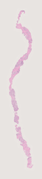

In [8]:
# load first biopsy and by simple means create non-overlapping grid with tissue areas
slide_path = sprob20_dir / 'imgs' / f'{biopsies[0]}.tif'
slide = open_slide(slide_path.as_posix())

# load thumb in scale 1/gridsize
grid_size = 512
 
fullres_w_h = np.array(slide.level_dimensions[0])

thumb = slide.get_thumbnail(np.int_(fullres_w_h/grid_size+0.5))
thumb

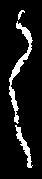

In [9]:
# simple background/foreground separation by otsu thresholding on the green channel
thres, mask = cv2.threshold(np.array(thumb)[:,:,1], 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
Image.fromarray(mask)

In [10]:
# create grid in full res with locations of tissue pixels
ys,xs = np.where(mask!=0)
grid_xy = np.array([[xs[i], ys[i]] for i in range(len(ys))]) * grid_size
len(grid_xy)

729

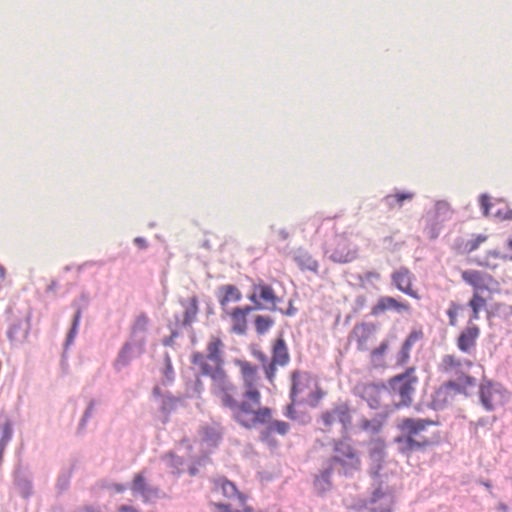

In [11]:
# read some patches
patch = slide.read_region(grid_xy[0], 0, (grid_size, grid_size))
patch

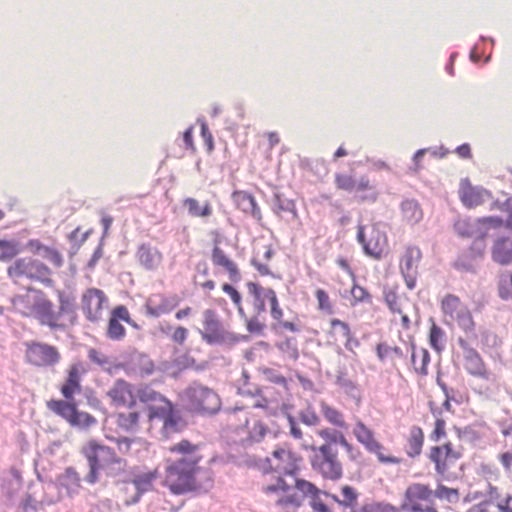

In [12]:
slide.read_region(grid_xy[1], 0, (grid_size, grid_size))

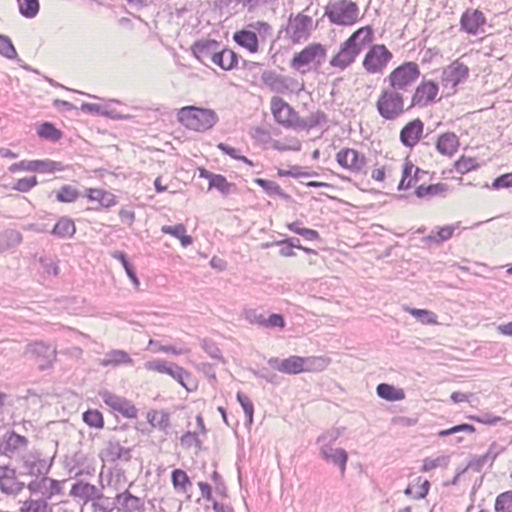

In [13]:
slide.read_region(grid_xy[60], 0, (grid_size, grid_size))

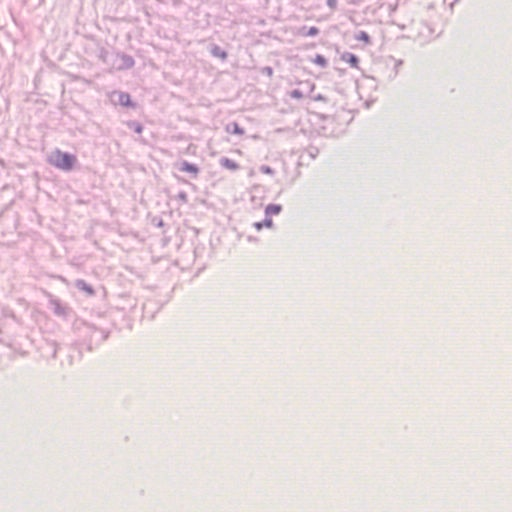

In [14]:
slide.read_region(grid_xy[-1], 0, (grid_size, grid_size))